# IMDb Horror Movie Scraper
# CMP-262 Maria Brisolla 05/13/2025 - Final Project

# KEY QUESTIONS

# Has the quality and rating of horror movies increased over the last few years?
# Are movies in this genre getting longer?
# Which subgenres are the most popular?
# What are the highest rated horror films of 2020 all the way up to 2024?

In [24]:
import requests
import pandas as pd
import time
from tqdm import tqdm

# API keys for TMDb and OMDb.  TMDb is used for pulliing IMDb IDs and OMDb is used for pulling ratings and titles
TMDB_API_KEY = "ac2ca9687cc4bcfd12644dfba459cd4c"
OMDB_API_KEY = "d84b5d14"

# Horror genre ID on TMDb
genre_id = 27
all_movies = []

print("Fetching from TMDb...")
for year in range(2020, 2025):
    for page in range(1, 6):  # up to 5 pages per year
        url = "https://api.themoviedb.org/3/discover/movie"
        params = {
            "api_key": TMDB_API_KEY,
            "language": "en-US",
            "sort_by": "vote_average.desc",
            "include_adult": "false",
            "include_video": "false",
            "page": page,
            "primary_release_year": year,
            "with_genres": genre_id,
            "vote_count.gte": 50
        }

        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error fetching TMDb year {year}, page {page}")
            break

        data = response.json().get("results", [])
        if not data:
            break

        for movie in data:
            all_movies.append({
                "Title": movie.get("title"),
                "Year": year,
                "TMDb ID": movie.get("id"),
                "TMDb Rating": movie.get("vote_average"),
                "Overview": movie.get("overview")
            })

        time.sleep(0.25)

df = pd.DataFrame(all_movies)

# Pull IMDb IDs from TMDb
print("Getting IMDb IDs from TMDb...")
imdb_ids = []
for tmdb_id in tqdm(df["TMDb ID"]):
    res = requests.get(f"https://api.themoviedb.org/3/movie/{tmdb_id}/external_ids",
                       params={"api_key": TMDB_API_KEY})
    imdb_id = res.json().get("imdb_id") if res.status_code == 200 else None
    imdb_ids.append(imdb_id)
    time.sleep(0.1)

df["IMDb ID"] = imdb_ids

# Pull IMDb Ratings from OMDb
print("Fetching IMDb ratings from OMDb...")
imdb_ratings = []
runtimes = []
genres = []

for imdb_id in tqdm(df["IMDb ID"]):
    if not imdb_id:
        imdb_ratings.append(None)
        runtimes.append(None)
        genres.append(None)
        continue

    omdb_url = "http://www.omdbapi.com/"
    params = {
        "apikey": OMDB_API_KEY,
        "i": imdb_id
    }
    res = requests.get(omdb_url, params=params)
    data = res.json()

    if data.get("Response") == "True":
        # Handle for 'N/A' IMDb ratings
        imdb_rating = data.get("imdbRating", "N/A")
        if imdb_rating != "N/A":
            imdb_ratings.append(float(imdb_rating))
        else:
            imdb_ratings.append(None)  # Set to None if rating is 'N/A'

        # Handle for runtime (potentially 'N/A')
        runtime = data.get("Runtime", "0 min").replace(" min", "").strip()
        runtimes.append(int(runtime) if runtime.isdigit() else None)

        # Handle for genre
        genres.append(data.get("Genre"))
    else:
        imdb_ratings.append(None)
        runtimes.append(None)
        genres.append(None)

    time.sleep(0.25)

# Add OMDb data to DataFrame
df["IMDb Rating"] = imdb_ratings
df["Runtime (min)"] = runtimes
df["Genre"] = genres

# Clean and save
df.dropna(subset=["IMDb Rating"], inplace=True)
df.sort_values("IMDb Rating", ascending=False, inplace=True)

df.to_csv("horror_movies_2020_2024_tmdb_omdb.csv", index=False)
print(f"\n Done! Saved {len(df)} movies to CSV.")
print(df.head(10))


Fetching from TMDb...
Getting IMDb IDs from TMDb...


100%|██████████| 500/500 [01:44<00:00,  4.78it/s]


Fetching IMDb ratings from OMDb...


100%|██████████| 500/500 [02:55<00:00,  2.85it/s]


 Done! Saved 495 movies to CSV.
                     Title  Year  TMDb ID  TMDb Rating  \
301     Godzilla Minus One  2023   940721        7.600   
427              Nosferatu  2024   426063        6.714   
407          The Substance  2024   933260        7.146   
103  A Quiet Place Part II  2021   520763        7.473   
204               The Menu  2022   593643        7.170   
5        The Invisible Man  2020   570670        7.110   
211      Werewolf by Night  2022   894205        6.979   
404         Alien: Romulus  2024   945961        7.203   
311              Red Rooms  2023   912480        7.085   
310             Talk to Me  2023  1008042        7.161   

                                              Overview     IMDb ID  \
301  In postwar Japan, Godzilla brings new devastat...  tt23289160   
427  A gothic tale of obsession between a haunted y...   tt5040012   
407  A fading celebrity decides to use a black mark...  tt17526714   
103  Following the events at home, the Abbott fa

# Sort all movies by ratings that are 7.0 or above
# Sort all by runtimes that exceed 100 minutes, or about an hour and a half

/var/folders/lt/zg7dk9012q9_sl448z9kdfsw0000gn/T/ipykernel_93347/501374646.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Year", y="% IMDb > 7.0", data=grouped, palette="Blues_d")


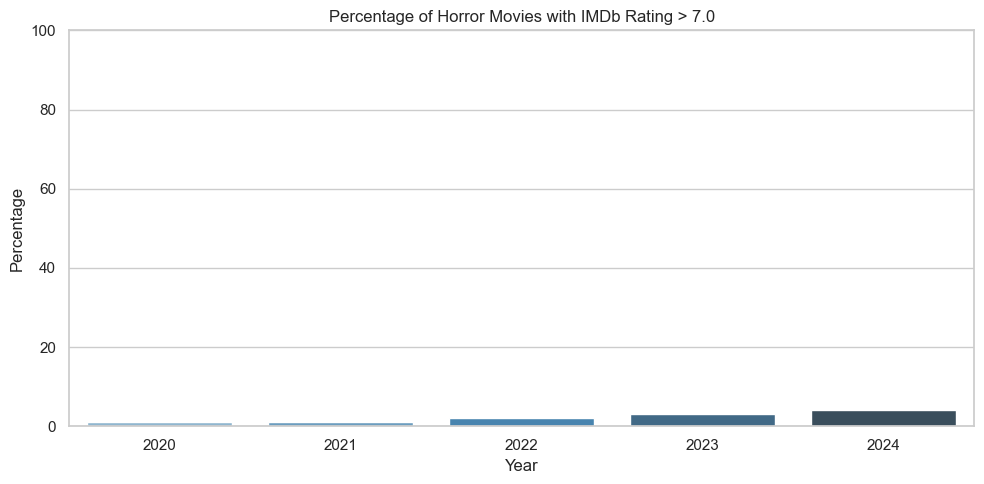

/var/folders/lt/zg7dk9012q9_sl448z9kdfsw0000gn/T/ipykernel_93347/501374646.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Year", y="% Runtime > 100min", data=grouped, palette="Oranges_d")


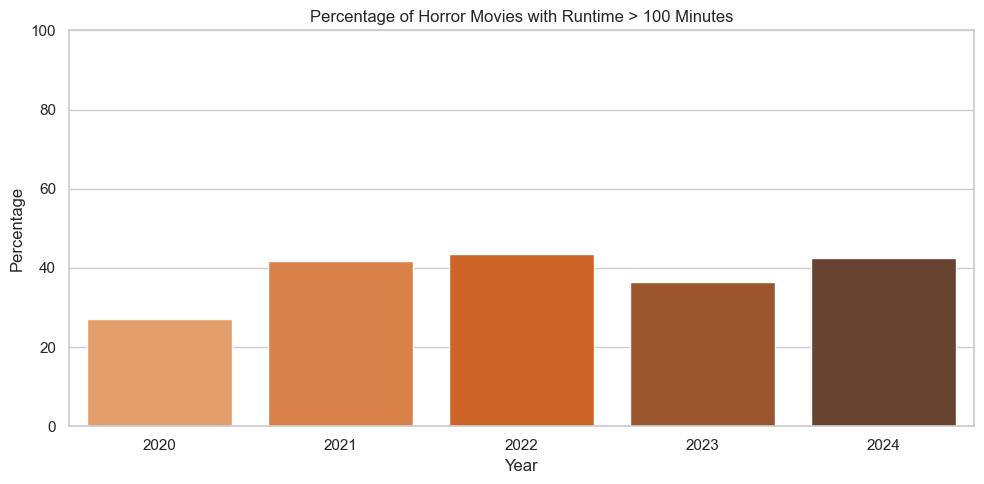

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure Year column is int
df["Year"] = df["Year"].astype(int)

# Group by year, calculate percentages
grouped = df.groupby("Year").agg(
    total_movies=("Title", "count"),
    over_7_rating=("IMDb Rating", lambda x: (x > 7.0).sum()),
    over_100_runtime=("Runtime (min)", lambda x: (x > 100).sum())
).reset_index()

# Calculate percentages
grouped["% IMDb > 7.0"] = (grouped["over_7_rating"] / grouped["total_movies"]) * 100
grouped["% Runtime > 100min"] = (grouped["over_100_runtime"] / grouped["total_movies"]) * 100

# Set Seaborn plot style
sns.set(style="whitegrid")

# Plot 1: IMDb Rating that are greater than 7.0
plt.figure(figsize=(10, 5))
sns.barplot(x="Year", y="% IMDb > 7.0", data=grouped, palette="Blues_d")
plt.title("Percentage of Horror Movies with IMDb Rating > 7.0")
plt.ylabel("Percentage")
plt.xlabel("Year")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Plot 2: Runtimes that exceed 100 min
plt.figure(figsize=(10, 5))
sns.barplot(x="Year", y="% Runtime > 100min", data=grouped, palette="Oranges_d")
plt.title("Percentage of Horror Movies with Runtime > 100 Minutes")
plt.ylabel("Percentage")
plt.xlabel("Year")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


# Filter highest rated movies by subgenre in the horror genre

/var/folders/lt/zg7dk9012q9_sl448z9kdfsw0000gn/T/ipykernel_93347/2436433499.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_counts.head(10), x="Count", y="Genre", palette="Purples_d")


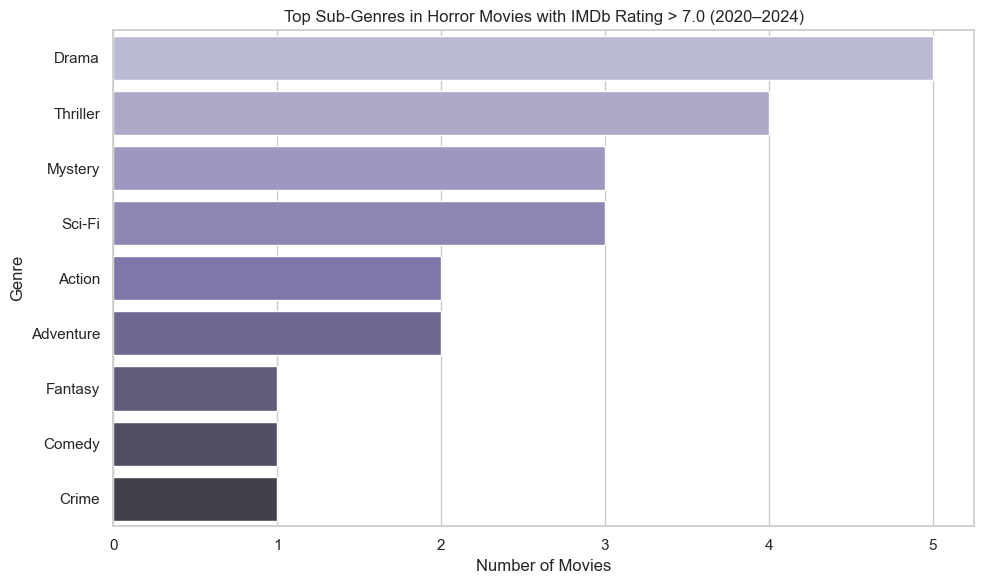

In [26]:
# Filter movies with IMDb rating > 7.0
high_rated = df[df["IMDb Rating"] > 7.0].copy()

# Split genres into lists
high_rated["Genre List"] = high_rated["Genre"].str.split(", ")
exploded_genres = high_rated.explode("Genre List")

# Remove "Horror" from sub-genre list
exploded_genres = exploded_genres[exploded_genres["Genre List"].str.lower() != "horror"]

# Count genre frequencies
genre_counts = exploded_genres["Genre List"].value_counts().reset_index()
genre_counts.columns = ["Genre", "Count"]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts.head(10), x="Count", y="Genre", palette="Purples_d")
plt.title("Top Sub-Genres in Horror Movies with IMDb Rating > 7.0 (2020–2024)")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


# Sort out the highest rated movies in the horror genre from 2020-2024

In [27]:
# Sort by IMDb Rating
top10 = df.sort_values("IMDb Rating", ascending=False).head(10)

# Display as table
print("Top 10 Highest-Rated Horror Movies (2020–2024):")
print(top10[["Title", "Year", "IMDb Rating", "Runtime (min)", "Genre"]])

Top 10 Highest-Rated Horror Movies (2020–2024):
                     Title  Year  IMDb Rating  Runtime (min)  \
301     Godzilla Minus One  2023          7.7          124.0   
407          The Substance  2024          7.3          141.0   
427              Nosferatu  2024          7.3          132.0   
103  A Quiet Place Part II  2021          7.2           97.0   
204               The Menu  2022          7.2          107.0   
5        The Invisible Man  2020          7.1          124.0   
211      Werewolf by Night  2022          7.1           52.0   
404         Alien: Romulus  2024          7.1          119.0   
311              Red Rooms  2023          7.1          118.0   
310             Talk to Me  2023          7.1           95.0   

                        Genre  
301  Action, Adventure, Drama  
407     Drama, Horror, Sci-Fi  
427  Fantasy, Horror, Mystery  
103     Drama, Horror, Sci-Fi  
204  Comedy, Horror, Thriller  
5      Drama, Horror, Mystery  
211  Action, Adventure,

# QUESTION 1

Yes, the quality/ratings of horror movies have gone up in the past few years, with a very steady percentage increase.  2020 had the least amount over 7.0, which is likely due to the circumstances of the ongoing Covid-19 pandemic at the time.

# QUESTION 2
From 2020 to 2021, there was a significant increase in runtime by nearly 20%, which only got a slight higher in 2022.  It dips below 40% in 2023 and dips back just above it in 2024.  In general, 2024 horror movies on average are longer than 2020 horror movies.

# QUESTION 3
Drama, Thriller, and Mystery are the most popular subgenres among the highest rated horror films.

# QUESTION 4
The top ten highest ranking movies for 2020-2024 are: Godzilla Minus One, The Substance, Nosferatu, A Quiet Place Part 2, The Menu, The Invisible Man, Werewolf by Night, Alien: Romulus, Red Rooms, and Talk to Me.  Seven of these ten films well exceed a runtime of 100 minutes, with The Substance being notibly well over 2 hours long.  This points back to question 2, which highlighted a slight trend in horror films becoming much longer.